Sent Voltage: 0.00V, Average Reading: 0.23V, Gain: 0.00
Sent Voltage: 0.02V, Average Reading: 0.47V, Gain: 12.81
Sent Voltage: 0.04V, Average Reading: 0.74V, Gain: 13.71
Sent Voltage: 0.06V, Average Reading: 0.98V, Gain: 13.59
Sent Voltage: 0.07V, Average Reading: 1.28V, Gain: 14.25
Sent Voltage: 0.09V, Average Reading: 1.55V, Gain: 14.32
Sent Voltage: 0.11V, Average Reading: 1.80V, Gain: 14.16
Sent Voltage: 0.13V, Average Reading: 2.09V, Gain: 14.45
Sent Voltage: 0.15V, Average Reading: 2.37V, Gain: 14.50
Sent Voltage: 0.17V, Average Reading: 2.64V, Gain: 14.51
Sent Voltage: 0.18V, Average Reading: 2.91V, Gain: 14.52
Sent Voltage: 0.20V, Average Reading: 3.15V, Gain: 14.41
Sent Voltage: 0.22V, Average Reading: 3.45V, Gain: 14.55
Sent Voltage: 0.24V, Average Reading: 3.70V, Gain: 14.47
Sent Voltage: 0.26V, Average Reading: 3.99V, Gain: 14.58
Sent Voltage: 0.28V, Average Reading: 4.24V, Gain: 14.51
Sent Voltage: 0.29V, Average Reading: 4.39V, Gain: 14.12
Sent Voltage: 0.31V, Average Rea

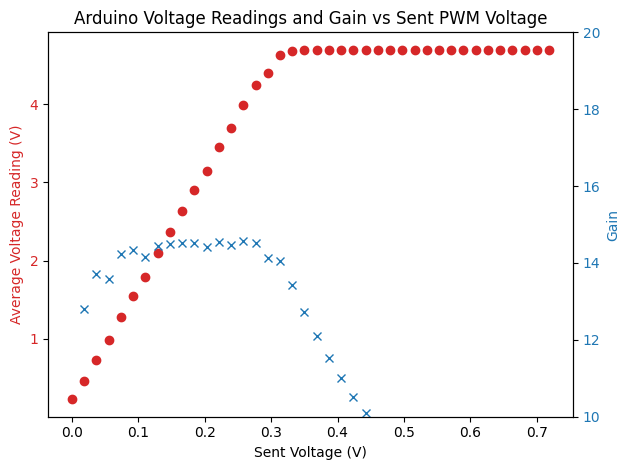

In [39]:
import serial
import time
import matplotlib.pyplot as plt

# Conversion Functions
def pwm_to_voltage(pwm):
    return (pwm / 255) * 4.7

def adc_to_voltage(adc):
    return (adc / 1023) * 4.7

# Set up serial communication
ser = serial.Serial('COM8', 115200, timeout=1)
time.sleep(2)  # Wait for the serial connection to initialize

sent_voltages = []
avg_voltages = []
avg_offsets = []
gains = []

try:
    for i in range(40):
        pwm_voltage = pwm_to_voltage(i)
        sent_voltages.append(pwm_voltage)
        ser.write(str(i).encode())  # Send the PWM value to the Arduino
        voltage_readings = []
        offset_readings = []

        # Read the first 10 values and average them
        for _ in range(10):
            ser.flush()
            line = ser.readline().decode('utf-8').strip()
            parts = line.split(',')
            if len(parts) == 2 and parts[0].isdigit() and parts[1].replace('.', '', 1).isdigit():
                adc_value = int(parts[0])
                offset_value = float(parts[1])
                voltage = adc_to_voltage(adc_value)
                offset_voltage = offset_value
                voltage_readings.append(voltage)
                offset_readings.append(offset_voltage)
            time.sleep(0.1)

        avg_reading = sum(voltage_readings) / len(voltage_readings)
        avg_offset = sum(offset_readings) / len(offset_readings)
        avg_voltages.append(avg_reading)
        avg_offsets.append(avg_offset)

        # Calculate gain and avoid division by zero
        corrected_reading = avg_reading - avg_offset
        gain = corrected_reading / pwm_voltage if pwm_voltage != 0 else 0
        gains.append(gain)

        print(f"Sent Voltage: {pwm_voltage:.2f}V, Average Reading: {avg_reading:.2f}V, Offset: {avg_offset:.2f}V, Gain: {gain:.2f}")

except KeyboardInterrupt:
    print("Program interrupted by the user")

finally:
    ser.close()

# Plotting the results with dual y-axis
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Sent Voltage (V)')
ax1.set_ylabel('Average Voltage Reading (V)', color=color)
ax1.plot(sent_voltages, avg_voltages, 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Gain', color=color)  
ax2.plot(sent_voltages, gains, 'x', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([10, 20])

plt.title('Arduino Voltage Readings, Offset, and Gain vs Sent PWM Voltage')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
